# 第八课：案例分析 - 泰坦尼克数据

* 本节课将重点分析泰坦尼克号沉船事故，我们将探索是**什么因素决定了最后是否生还**。
* 我们将将前面课程所学过的知识点融会贯通，举一反三
* 新增知识点：
    * 缺失值处理：pandas中的fillna()方法
    * 数据透视表：pandas中的pivot_table函数

<img src="titanic.jpeg">

### 泰坦尼克号背景介绍
泰坦尼克号是一艘奥林匹克级邮轮，于1912年4月首航时撞上冰山后沉没。泰坦尼克号由位于北爱尔兰贝尔法斯特的哈兰·沃尔夫船厂兴建，是当时最大的客运轮船，由于其规模相当一艘现代航空母舰，因而号称“上帝也沉没不了的巨型邮轮”。在泰坦尼克号的首航中，从英国南安普敦出发，途经法国瑟堡-奥克特维尔以及爱尔兰昆士敦，计划横渡大西洋前往美国纽约市。但因为人为错误，于1912年4月14日船上时间夜里11点40分撞上冰山；2小时40分钟后，即4月15日凌晨02点20分，船裂成两半后沉入大西洋，死亡人数超越1500人，堪称20世纪最大的海难事件，同时也是最广为人知的海难之一。
<img src="news.jpeg">

## 1、数据导入和观察

In [1]:
# 读取常用的包
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# 读取数据
titanic_df = pd.read_csv('titanic.csv')

In [3]:
# 查看前五行数据
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


** 数据字段说明 **

* PassengerId:  乘客的id
* Survival: 	是否幸存	0 = No, 1 = Yes
* Pclass:	舱位        class	1 = 1st, 2 = 2nd, 3 = 3rd
* Name:     姓名
* Sex:	    性别
* Age:	    年龄
* SibSp:	    船上兄弟姐妹以及配偶的个数
* Parch:     船上父母以及者子女的个数
* Ticket:	船票号码	
* Fare:	票价
* Cabin:	船舱号码
* Embarked: 登船码头 C = Cherbourg, Q = Queenstown, S = Southampton

** 变量类型**
* 数值变量：Age, SibSp, Parch, 和Fare。
* 分类变量：Pcalss, Sex, Cabin, 和Embarked。Survived是结果。

### 数据的统计描述

* 数值变量

In [4]:
# describe函数查看部分变量的分布
# 因为Survived是0-1变量，所以均值就是幸存人数的百分比，这个用法非常有用
titanic_df[["Survived","Age", "SibSp", "Parch"]].describe()

,Survived,Age,SibSp,Parch
count,891.000000,714.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594
std,0.486592,14.526497,1.102743,0.806057
min,0.000000,0.420000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000
50%,0.000000,28.000000,0.000000,0.000000
75%,1.000000,38.000000,1.000000,0.000000
max,1.000000,80.000000,8.000000,6.000000


* 分类变量

In [5]:
# 使用include=[np.object]来查看分类变量
# count: 非缺失值的个数
# unique: 非重复值得个数
# top: 最高频值
# freq: 最高频值出现次数
titanic_df.describe(include=[np.object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Cherry, Miss. Gladys",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


### 不同舱位的分布情况是怎样的呢？

*我们通过这个例子来复习 value_counts 和 group_by*

In [6]:
# 方法1: value_counts
# 查看不同舱位的分布
# 头等舱：24%； 二等舱：21%； 三等舱：55%
# value_counts 频数统计， len() 获取数据长度
titanic_df.Pclass.value_counts() / len(titanic_df)  #value_counts在第5节课中讲解过

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

In [7]:
# 方法2：group_by
# sort_values 将结果排序
(titanic_df.groupby("Pclass").agg("size") / len(titanic_df)).sort_values(ascending=False)

Pclass
3    0.551066
1    0.242424
2    0.206510
dtype: float64

## 作业8-1：
查看Embarked(登船码头)人数分布的百分比

## 2、缺失值处理
* 真实数据往往某些变量会有缺失值。
* 这里，cabin有超过70%以上的缺失值，我们可以考虑直接丢掉这个变量。 -- 删除某一列数据
* 像Age这样的重要变量，有20%左右的缺失值，我们可以考虑用中位值来填补。-- 填补缺失值
* 我们一般不提倡去掉带有缺失值的行，因为其他非缺失的变量可能提供有用的信息。-- 删除带缺失值的行

In [8]:
# 总共有891个乘客
# Age有714个非缺失值，Cabin只有204个非缺失值。我们将会讲解如何处理缺失值
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 填补年龄数据中的缺失值
* 直接使用所有人年龄的中位数来填补

In [9]:
# 在处理之前，查看Age列的统计值
titanic_df.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [10]:
# 重新载入原始数据
titanic_df=pd.read_csv("titanic.csv")

# 计算所有人年龄的均值
age_median1 = titanic_df.Age.median()

# 使用fillna填充缺失值，inplace=True表示在原数据titanic_df上直接进行修改
titanic_df.Age.fillna(age_median1, inplace=True)

# 查看Age列的统计值
titanic_df.Age.describe()

count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

* 考虑性别因素，分别用男女乘客各自年龄的中位数来填补

In [11]:
# 重新载入原始数据
titanic_df=pd.read_csv("titanic.csv")

# 分组计算男女年龄的中位数， 得到一个Series数据，索引为Sex
age_median2 = titanic_df.groupby('Sex').Age.median()

# 设置Sex为索引
titanic_df.set_index('Sex', inplace=True)
# 使用fillna填充缺失值，根据索引值填充
titanic_df.Age.fillna(age_median2, inplace=True)
# 重置索引，即取消Sex索引
titanic_df.reset_index(inplace=True)

# 查看Age列的统计值
titanic_df.Age.describe()

count    891.000000
mean      29.441268
std       13.018747
min        0.420000
25%       22.000000
50%       29.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

* 同时考虑性别和舱位因素

In [12]:
# 重新载入原始数据
titanic_df=pd.read_csv("titanic.csv")

# 分组计算不同舱位男女年龄的中位数， 得到一个Series数据，索引为Pclass,Sex
age_median3 = titanic_df.groupby(['Pclass', 'Sex']).Age.median()

# 设置Pclass, Sex为索引， inplace=True表示在原数据titanic_df上直接进行修改
titanic_df.set_index(['Pclass','Sex'], inplace=True)
# 使用fillna填充缺失值，根据索引值填充
titanic_df.Age.fillna(age_median3, inplace=True)
# 重置索引，即取消Pclass,Sex索引
titanic_df.reset_index(inplace=True)

# 查看Age列的统计值
titanic_df.Age.describe()

count    891.000000
mean      29.112424
std       13.304424
min        0.420000
25%       21.500000
50%       26.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

## 3、分析哪些因素会决定生还概率

###  3-1 舱位与生还概率


* 计算每个舱位的生还概率

In [13]:
# 方法1：使用经典的分组-聚合-计算（第六节课核心内容）
# 注意：因为Survived是0-1函数，所以均值即表示生还百分比
titanic_df[['Pclass', 'Survived']].groupby('Pclass').mean() \
    .sort_values(by='Survived', ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [14]:
# 方法2：我们还可以使用pivot_table函数来实现同样的功能（本次课新内容）
# pivot table中文为数据透视表
# values: 聚合后被施加计算的值，这里我们施加mean函数
# index: 分组用的变量
# aggfunc: 定义施加的函数
titanic_df.pivot_table(values='Survived', index='Pclass', aggfunc=np.mean)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


* 绘制舱位和生还概率的条形图

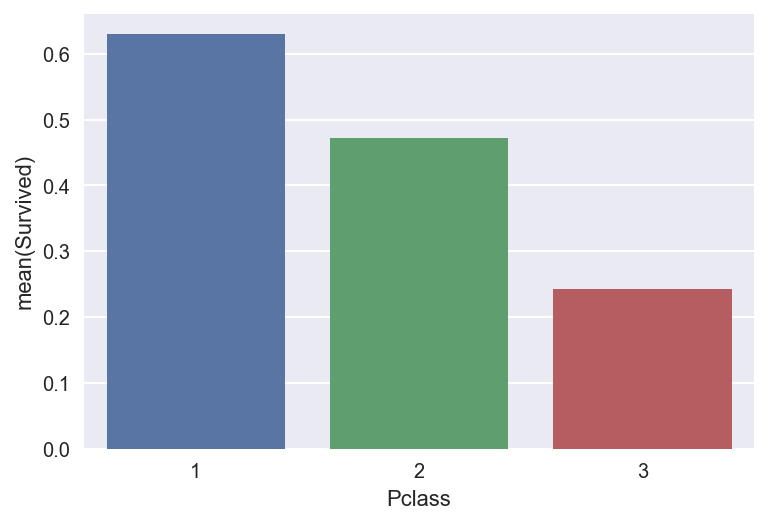

In [15]:
# 使用sns.barplot做条形图，图中y轴给出 Survived 均值的点估计
sns.barplot(data=titanic_df, x='Pclass', y='Survived', ci=None)

**结论**：头等舱的生还概率最大，其次是二等舱，三等舱的概率最小。

### 3-2 性别与生还概率

In [16]:
# 方法1：groupby
titanic_df[["Sex", "Survived"]].groupby('Sex').mean() \
    .sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


In [17]:
# 方法2：pivot_table
titanic_df.pivot_table(values='Survived', index='Sex', aggfunc=np.mean)

,Survived
Sex,
female,0.742038
male,0.188908


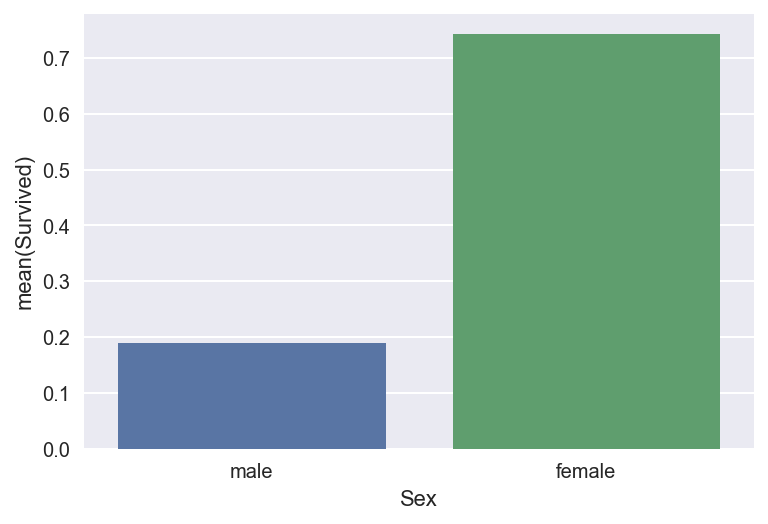

In [18]:
# 绘制条形图
sns.barplot(data=titanic_df, x='Sex', y='Survived', ci=None)

 #### **结论**：女性幸存概率远远大于男性!

### 3-3 综合考虑舱位和性别的因素，与生还概率的关系

In [19]:
# 方法1：groupby
titanic_df[['Pclass','Sex', 'Survived']].groupby(['Pclass', 'Sex']).mean() 

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

In [20]:
# 方法2：pivot_table
titanic_df.pivot_table(values='Survived', index=['Pclass', 'Sex'], aggfunc=np.mean)

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

In [21]:
# 方法3：pivot_talbe
# columns指定另一个分类变量，只不过我们将它列在列里而不是行里，这也是为什么这个变量称为columns
titanic_df.pivot_table(values='Survived', index='Pclass', columns="Sex", aggfunc=np.mean)

Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


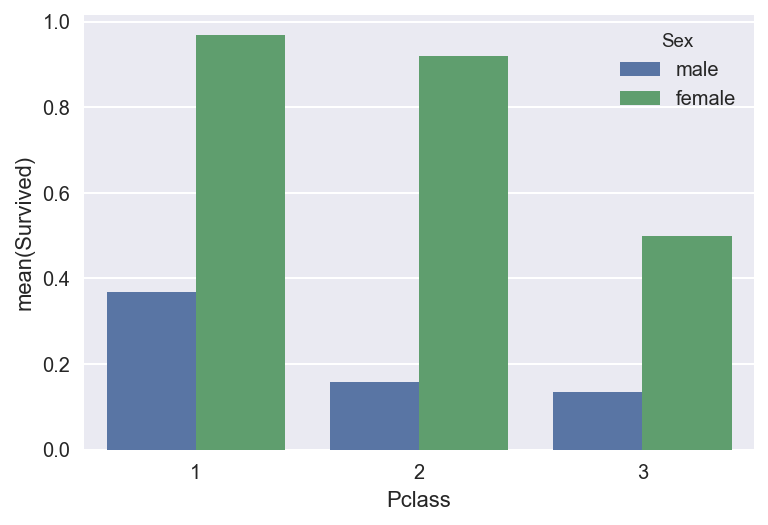

In [22]:
# 绘制条形图：使用sns.barplot
sns.barplot(data=titanic_df, x='Pclass', y='Survived', hue='Sex', ci=None)

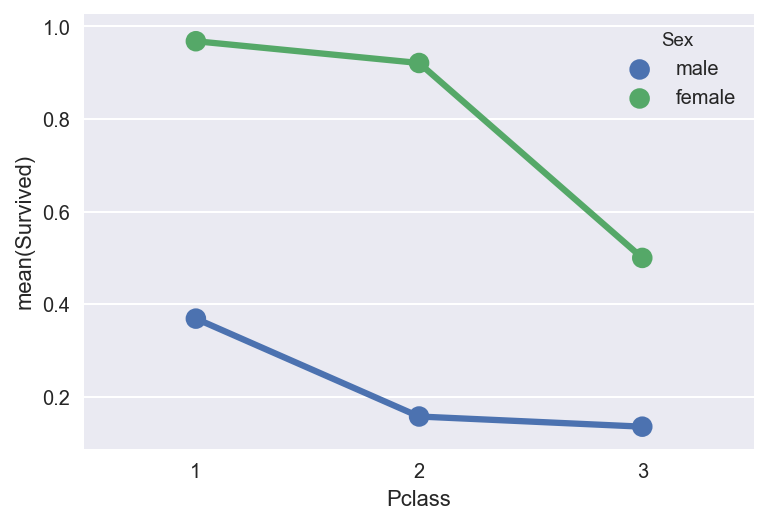

In [23]:
# 绘制折线图：使用sns.pointplot
sns.pointplot(data=titanic_df, x='Pclass', y='Survived', hue='Sex', ci=None)

**结论**：在各个舱位中，女性的生还概率都远大于男性。一二等舱的女性生还率接近，且远大于三等舱。一等舱的男性生还率大于二三等舱，二三等舱的男性生还率接近。

## 作业8-2：
分别使用groupby和pivot_table, 计算在不同舱位中男女乘客的人数。（提示，使用count。）

### 3-4 年龄与生还情况
与上面的舱位、性别这些分类变量不同，年龄是一个连续的变量。

* 生还组和罹难组的年龄分布直方图

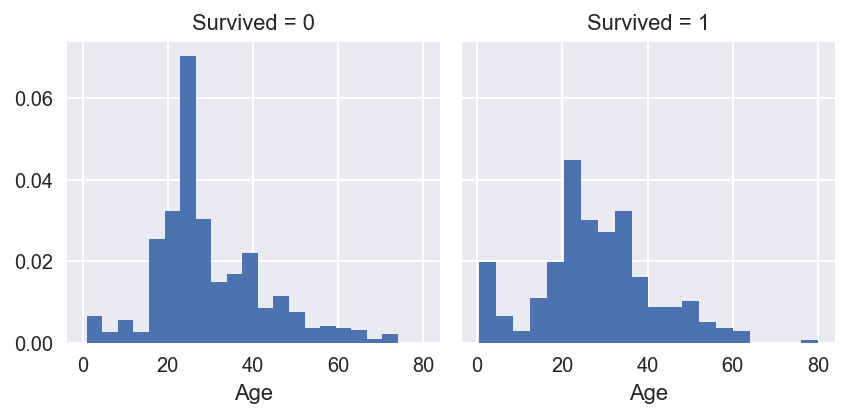

In [24]:
# 使用seaborn包中的 FacetGrid().map() 来快速生成高质量图片（在第七节课中讲解过）
# col='Survived'指定将图片在一行中做出生还和罹难与年龄的关系图
sns.FacetGrid(titanic_df, col='Survived').\
    map(plt.hist, 'Age', bins=20, normed=True)

**结论**：儿童有更高的生还可能。

## 作业 8-3： 
考虑舱位因素后，绘制生还组和罹难组的年龄分布直方图
*提示：FacetGrid参数中同时设置col和row*

#### ** 将连续型变量离散化**
* 连续型变量离散化是建模中一种常用的方法
* 离散化指的是将某个变量的所在区间分割为几个小区间，落在同一个区间的观测值用同一个符号表示
* 以年龄为例，最小值是0.42（婴儿），最大值是80，如果我们想产生一个五个级（levels），我们可使用cut或者qcut函数
* cut函数将年龄的区间均匀分割为5分，而qcut则选取区间以至于每个区间里的观察值个数都是一样的（五等分）， 这里演示中使用cut函数。

In [25]:
# 我们使用cut函数
# 我们可以看到每个区间的大小是固定的，大约是16岁
titanic_df['AgeBand'] = pd.cut(titanic_df['Age'], 5)
titanic_df.head()

,Pclass,Sex,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand
0,3,male,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,"(16.336, 32.252]"
1,1,female,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,"(32.252, 48.168]"
2,3,female,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(16.336, 32.252]"
3,1,female,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,"(32.252, 48.168]"
4,3,male,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,"(32.252, 48.168]"


* 查看落在不同年龄区间里的人数

In [26]:
# 方法1：value_counts(), sort=False表示不需要将结果排序
titanic_df.AgeBand.value_counts(sort=False)

(0.34, 16.336]      100
(16.336, 32.252]    493
(32.252, 48.168]    218
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: AgeBand, dtype: int64

In [27]:
# 方法2：pivot_table
titanic_df.pivot_table(values='Survived',index='AgeBand', aggfunc='count')

,Survived
AgeBand,
"(0.34, 16.336]",100
"(16.336, 32.252]",493
"(32.252, 48.168]",218
"(48.168, 64.084]",69
"(64.084, 80.0]",11


* 查看各个年龄区间的生还率

In [28]:
titanic_df.pivot_table(values='Survived',index='AgeBand', aggfunc=np.mean)

,Survived
AgeBand,
"(0.34, 16.336]",0.550000
"(16.336, 32.252]",0.336714
"(32.252, 48.168]",0.412844
"(48.168, 64.084]",0.434783
"(64.084, 80.0]",0.090909


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

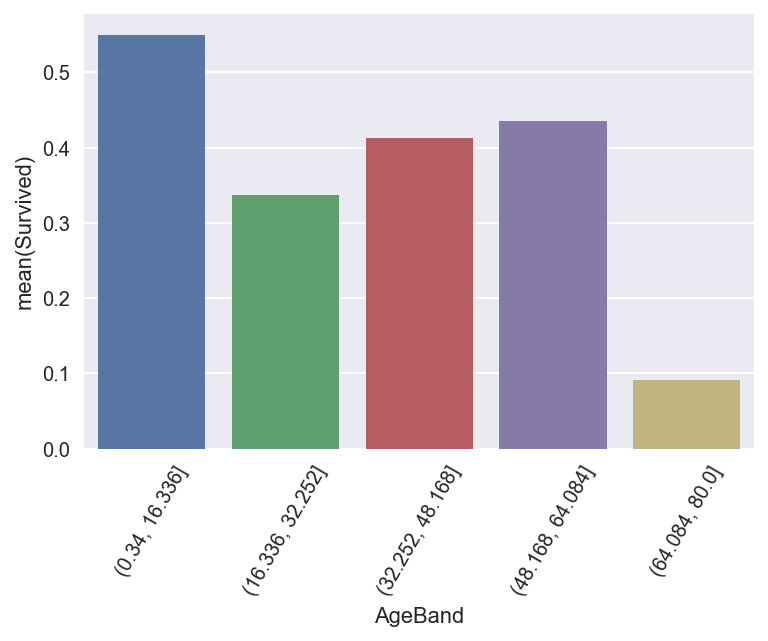

In [29]:
sns.barplot(data=titanic_df, x='AgeBand', y='Survived', ci=None)
plt.xticks(rotation=60)

* 结论：儿童的生还率更高。

### 3-5 年龄、性别 与生还概率

In [30]:
# 查看落在不同区间里男女的生还概率
titanic_df.pivot_table(values='Survived',index='AgeBand', columns='Sex', aggfunc=np.mean)

Sex,female,male
AgeBand,,
"(0.34, 16.336]",0.673469,0.431373
"(16.336, 32.252]",0.701220,0.155015
"(32.252, 48.168]",0.818182,0.191489
"(48.168, 64.084]",0.916667,0.177778
"(64.084, 80.0]",NaN,0.090909


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

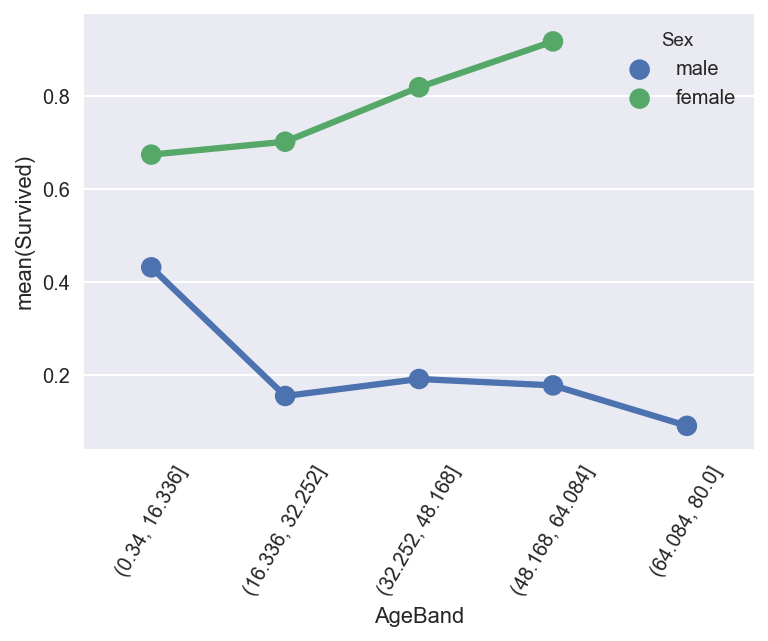

In [31]:
sns.pointplot(data=titanic_df, x='AgeBand', y='Survived', hue='Sex', ci=None)
plt.xticks(rotation=60)

### 3-6 年龄、舱位、性别 与生还概率

In [32]:
titanic_df.pivot_table(values='Survived',index='AgeBand', columns=['Sex', 'Pclass'], aggfunc=np.mean)

Sex                 female                          male                    
Pclass                   1         2         3         1         2         3
AgeBand                                                                     
(0.34, 16.336]    0.833333  1.000000  0.545455  1.000000  0.818182  0.270270
(16.336, 32.252]  0.968750  0.921053  0.521277  0.444444  0.087719  0.138776
(32.252, 48.168]  1.000000  0.909091  0.250000  0.366667  0.074074  0.055556
(48.168, 64.084]  0.941176  0.833333  1.000000  0.269231  0.090909  0.000000
(64.084, 80.0]         NaN       NaN       NaN  0.166667  0.000000  0.000000

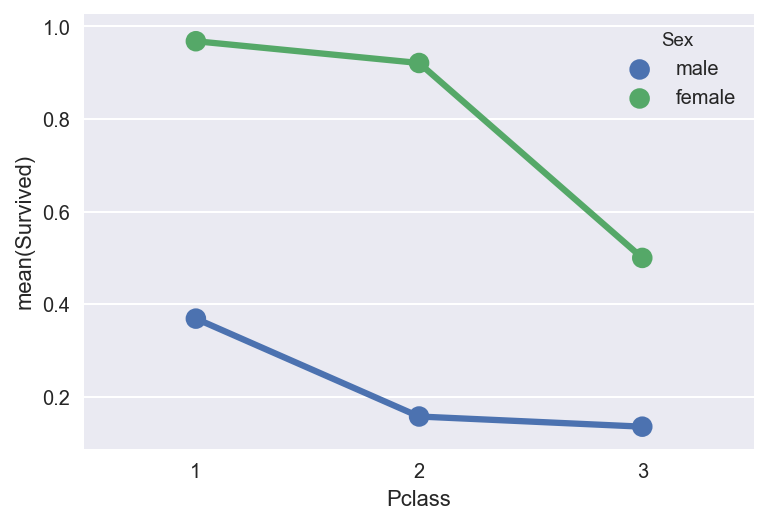

In [33]:
# 回顾sns.pointplot 绘制舱位、性别与生还概率的关系图
sns.pointplot(data=titanic_df, x='Pclass', y='Survived', hue='Sex', ci=None)

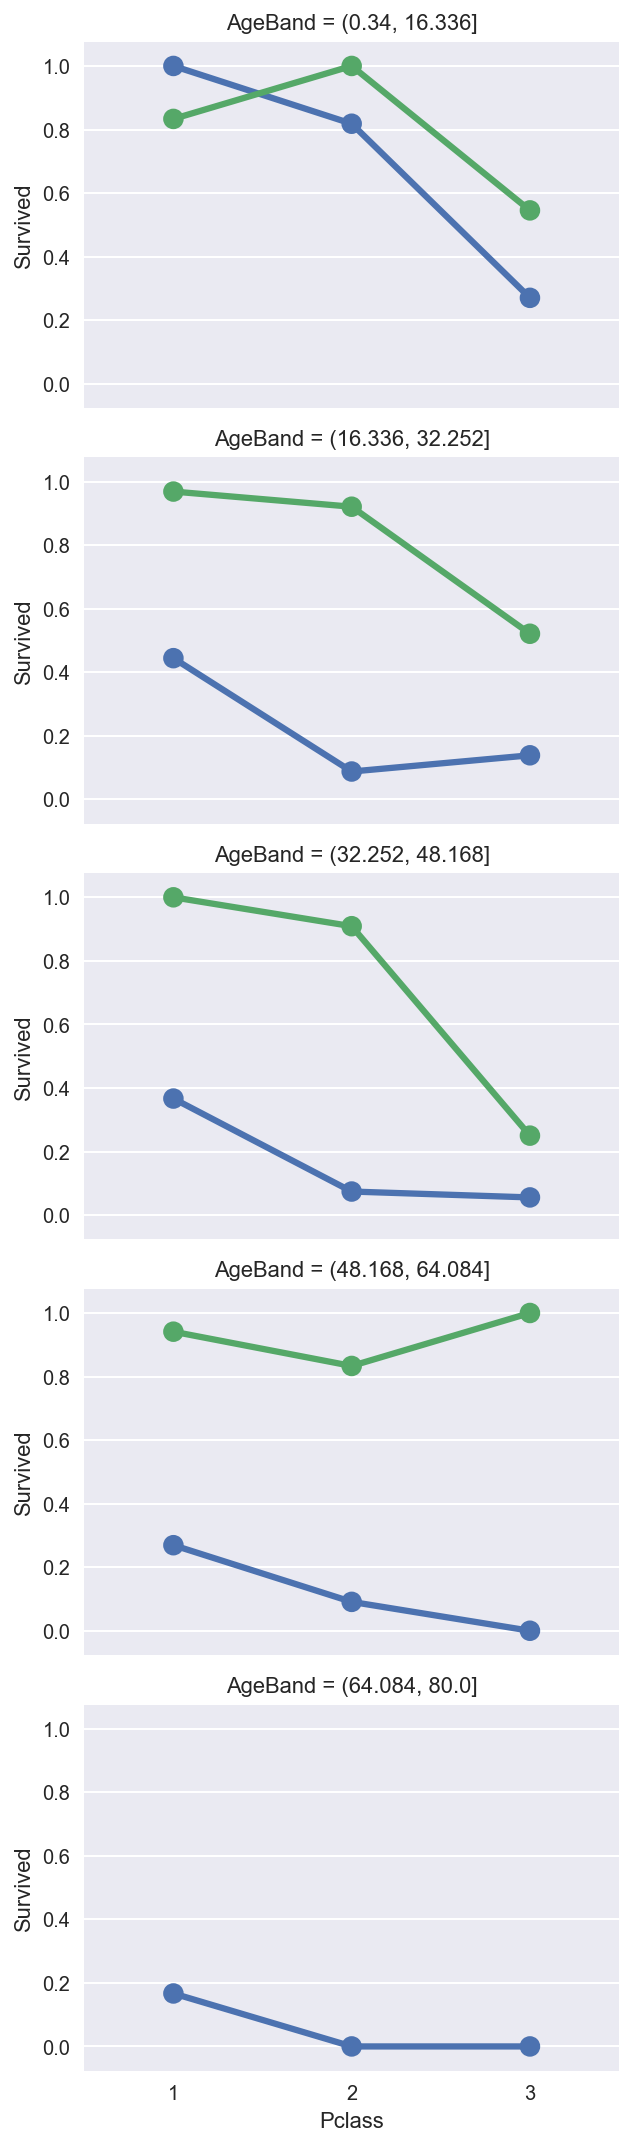

In [34]:
# 同时绘制不同年龄组的生还概率图
# 参数row='AgeBand'表示将不同的年龄区间的图按行排列
# 参数aspect设置画布的长宽比
# 参数palette（调色板）设置hue分组的颜色
sns.FacetGrid(data = titanic_df, row='AgeBand', aspect=1.5) \
   .map(sns.pointplot, 'Pclass', 'Survived', 'Sex', hue_order=['male', 'female'],  palette='deep', ci=None)

*palette 配色参考* https://seaborn.pydata.org/tutorial/color_palettes.html?highlight=palette 

## 作业8-4:
综合考虑性别，舱位和登船码头三个因素，计算其生还概率，并在一副图中探索它们和生还概率的关系。